### Compare cerebellar volumes across datasets

#### Datasets
- NIMHANS
- QPN


In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nibabel as nib
from nilearn import datasets, surface, plotting


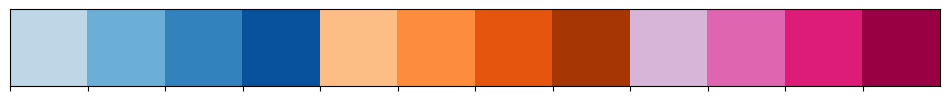

In [2]:
from enum import Enum
# class my_colors(Enum):
#     NIM_SERB_CONTROL = "#a6bddb"
#     NIM_SERB_PD = "#2c7fb8"
#     NIM_METAL_CONTROL = "#addd8e"
#     NIM_METAL_PD = "#31a354"

#     QPN_CONTROL = "#fa9fb5"
#     QPN_PD = "#dd1c77"
#     QPN_older_CONTROL = "#ae017e"
#     QPN_older_PD = "#7a0177"
#     PPMI_CONTROL = "#fecc5c"
#     # PPMI_PRODROMAL = "#fecc5c"
#     PPMI_PD = "#fd8d3c"
#     PPMI_older_CONTROL = "#e31a1c"
#     PPMI_older_PD = "#b10026"

# Poster colors
class my_colors(Enum):
    NIM_SERB_CONTROL =  "#bdd7e7"
    NIM_SERB_PD =       "#6baed6"
    NIM_METAL_CONTROL = "#3182bd"
    NIM_METAL_PD =      "#08519c"

    QPN_CONTROL =       "#fdbe85"
    QPN_PD =            "#fd8d3c"
    QPN_older_CONTROL = "#e6550d"
    QPN_older_PD =      "#a63603"

    PPMI_CONTROL =      "#d7b5d8"
    PPMI_PD =           "#df65b0"
    PPMI_older_CONTROL= "#dd1c77"
    PPMI_older_PD =     "#980043"
    

color_list = [  my_colors.NIM_SERB_CONTROL.value, my_colors.NIM_SERB_PD.value,
                my_colors.NIM_METAL_CONTROL.value, my_colors.NIM_METAL_PD.value,
                my_colors.QPN_CONTROL.value, my_colors.QPN_PD.value, 
                my_colors.QPN_older_CONTROL.value, my_colors.QPN_older_PD.value,
                my_colors.PPMI_CONTROL.value, my_colors.PPMI_PD.value,
                my_colors.PPMI_older_CONTROL.value, my_colors.PPMI_older_PD.value              
              ]

palette = sns.color_palette(palette=color_list) #sns.husl_palette()

hue_order = ["NIMHANS-1-control", "NIMHANS-1-PD", "NIMHANS-2-control", "NIMHANS-2-PD", 
             "QPN-young-control", "QPN-young-PD", "QPN-older-control", "QPN-older-PD",
             "PPMI-young-control",  "PPMI-young-PD","PPMI-older-control",  "PPMI-older-PD"] #"PPMI-prodromal",

sns.palplot(palette)

In [3]:
projects_dir = f"/home/nikhil/projects/Parkinsons//neuro_arch/analysis" 

IDP_dir = f"{projects_dir}/IDP"
figs_dir = f"{projects_dir}/figures/ADPD/poster/"

qpn_release = "Jan_2024"

nimhans_serb_agg_data_dir = f"{IDP_dir}/nimhans_serb/agg_dfs/"
nimhans_metal_agg_data_dir = f"{IDP_dir}/nimhans_metal/agg_dfs/"
qpn_agg_data_dir = f"{IDP_dir}/qpn/{qpn_release}/agg_dfs/"
ppmi_agg_data_dir = f"{IDP_dir}/ppmi/agg_dfs/"

CB_vol_csv = "cerebellar_volumes.csv"

global_vol_csv = "global_vol_ASEG_df.csv"

# save dirs
figs_dir = "/home/nikhil/projects/Parkinsons/neuro_arch/analysis/figures/ADPD/poster/"

demo_cols = ["participant_id","age","sex","group","hemi","dataset"]

### Read global volumes (i.e. ASEG and demo df)

In [4]:
match_age = False
age_thresh = 63

# NIMHANS_SERB
nimhans_serb_global_ASEG_df = pd.read_csv(f"{nimhans_serb_agg_data_dir}{global_vol_csv}").drop(columns=["Unnamed: 0"])
nimhans_serb_global_ASEG_df["dataset"] = "NIMHANS-1"
n_nimhans_serb_participants = len(nimhans_serb_global_ASEG_df["participant_id"].unique())

# NIMHANS_METAL
nimhans_metal_global_ASEG_df = pd.read_csv(f"{nimhans_metal_agg_data_dir}{global_vol_csv}").drop(columns=["Unnamed: 0"])
nimhans_metal_global_ASEG_df["dataset"] = "NIMHANS-2"
n_nimhans_metal_participants = len(nimhans_metal_global_ASEG_df["participant_id"].unique())

# QPN
qpn_global_ASEG_df = pd.read_csv(f"{qpn_agg_data_dir}{global_vol_csv}").drop(columns=["Unnamed: 0"])
qpn_global_ASEG_df["dataset"] = "QPN"
n_qpn_participants = len(qpn_global_ASEG_df["participant_id"].unique())

# QPN
ppmi_global_ASEG_df = pd.read_csv(f"{ppmi_agg_data_dir}{global_vol_csv}").drop(columns=["Unnamed: 0"])
ppmi_global_ASEG_df["dataset"] = "PPMI"
n_ppmi_participants = len(ppmi_global_ASEG_df["participant_id"].unique())

print(f"n_nimhans_participants: {(n_nimhans_serb_participants, n_nimhans_metal_participants)}")
print(f"n_qpn_participants:{n_qpn_participants}, n_ppmi_participants: {n_ppmi_participants}")

if match_age:
    print(f"filter age < {age_thresh}")
    qpn_global_ASEG_df = qpn_global_ASEG_df[qpn_global_ASEG_df["age"] < age_thresh]
    n_qpn_participants = len(qpn_global_ASEG_df["participant_id"].unique())
    print(f"n_nimhans_participants: {(n_nimhans_serb_participants)}, n_qpn_participants:{n_qpn_participants}")


nimhans_serb_demo_df = nimhans_serb_global_ASEG_df[demo_cols]

# METAL has weird participant_id (original ones)
nimhans_metal_global_ASEG_df["participant_id"] = nimhans_metal_global_ASEG_df["bids_id"].str.split("-", expand=True)[1]
nimhans_metal_demo_df = nimhans_metal_global_ASEG_df[demo_cols]

qpn_demo_df = qpn_global_ASEG_df[demo_cols]

ppmi_demo_df = ppmi_global_ASEG_df[demo_cols]
ppmi_demo_df = ppmi_demo_df.dropna(subset=["participant_id"])
ppmi_demo_df["participant_id"] = ppmi_demo_df["participant_id"].astype(int).astype(str)

nimhans_metal_demo_df.head()

n_nimhans_participants: (86, 130)
n_qpn_participants:287, n_ppmi_participants: 406


,participant_id,age,sex,group,hemi,dataset
0,METAL079,50.0,M,PD,global,NIMHANS-2
1,METALHC029,53.0,M,control,global,NIMHANS-2
2,METAL076,39.0,M,PD,global,NIMHANS-2
3,METAL023,57.0,M,PD,global,NIMHANS-2
4,METALHC010,65.0,M,control,global,NIMHANS-2


### Get merged cerebellar volumes + demo df

In [5]:
cerebellar_lobules = ['I_II', 'III', 'IV', 'V', 'VI', 'Crus_I', 'Crus_II','VIIB', 'VIIIA', 'VIIIB', 'IX', 'X', 'CM']

def merge_CB_demo_df(CB_df, demo_df, cerebellar_lobules):
    left_lobules = list("L_" + pd.Series(cerebellar_lobules))
    right_lobules = list("R_" + pd.Series(cerebellar_lobules))
    lh_lobule_dict = dict(zip(left_lobules,cerebellar_lobules))
    rh_lobule_dict = dict(zip(right_lobules,cerebellar_lobules))

    CB_df["bids_id"] = CB_df["Subject"].str.rsplit("/", n=1, expand=True)[1].str.split("_", expand=True)[0]
    CB_df["participant_id"] = CB_df["bids_id"].str.split("-", expand=True)[1]

    # merge with demo
    CB_demo_df = pd.merge(CB_df, demo_df, on="participant_id", how="inner")
    CB_demo_df = CB_demo_df.drop(columns=["Subject"])

    demo_cols = list(set(CB_demo_df.columns) - set(left_lobules) - set(right_lobules))

    left_CB_df = CB_demo_df[demo_cols + left_lobules].copy()
    left_CB_df["hemi"] = "left"
    right_CB_df = CB_demo_df[demo_cols + right_lobules].copy()
    right_CB_df["hemi"] = "right"

    # add total CB vol column
    left_CB_df["total_CB_vol"] = left_CB_df[left_lobules].sum(axis=1)
    right_CB_df["total_CB_vol"] = right_CB_df[right_lobules].sum(axis=1)

    # rename columns to stack vertically
    left_CB_df = left_CB_df.rename(columns=lh_lobule_dict)
    right_CB_df = right_CB_df.rename(columns=rh_lobule_dict)
    
    CB_demo_df = pd.concat([left_CB_df, right_CB_df], axis=0)

    return CB_demo_df

In [6]:
# nimhans-serb
nimhans_serb_CB_vols_df = pd.read_csv(f"{nimhans_serb_agg_data_dir}/{CB_vol_csv}")
nimhans_serb_CB_vols_df = merge_CB_demo_df(nimhans_serb_CB_vols_df, nimhans_serb_demo_df, cerebellar_lobules)

# nimhans-metal
nimhans_metal_CB_vols_df = pd.read_csv(f"{nimhans_metal_agg_data_dir}/{CB_vol_csv}")
nimhans_metal_CB_vols_df = merge_CB_demo_df(nimhans_metal_CB_vols_df, nimhans_metal_demo_df, cerebellar_lobules)

# qpn
qpn_CB_vols_df = pd.read_csv(f"{qpn_agg_data_dir}/{CB_vol_csv}")
qpn_CB_vols_df = merge_CB_demo_df(qpn_CB_vols_df, qpn_demo_df, cerebellar_lobules)

# qpn
ppmi_CB_vols_df = pd.read_csv(f"{ppmi_agg_data_dir}/{CB_vol_csv}")
ppmi_CB_vols_df = merge_CB_demo_df(ppmi_CB_vols_df, ppmi_demo_df, cerebellar_lobules)

CB_vol_df = pd.concat([nimhans_serb_CB_vols_df, nimhans_metal_CB_vols_df, qpn_CB_vols_df, ppmi_CB_vols_df], axis=0)

CB_vol_df.head()

,dataset,age,participant_id,bids_id,sex,hemi,group,I_II,III,IV,...,VI,Crus_I,Crus_II,VIIB,VIIIA,VIIIB,IX,X,CM,total_CB_vol
0,NIMHANS-1,60.0,SERB004,sub-SERB004,M,left,control,73.9998,588.999,1878.0,...,5927.99,8909.98,5652.99,2768.99,4209.99,3256.99,3263.99,450.999,7470.98,47297.8878
1,NIMHANS-1,NaN,SERB002,sub-SERB002,NaN,left,control,62.0000,724.000,2013.0,...,6553.00,10837.00,8699.00,4216.00,5801.00,3125.00,3726.00,541.000,7966.00,57313.0000
2,NIMHANS-1,47.0,SERB003,sub-SERB003,M,left,control,77.0000,873.000,1985.0,...,7195.00,10330.00,6189.00,3279.00,5076.00,2997.00,2454.00,459.000,7560.00,51935.0000
3,NIMHANS-1,56.0,SERB001,sub-SERB001,M,left,control,58.0000,804.000,2243.0,...,6728.00,10737.00,6656.00,3175.00,5106.00,3515.00,3331.00,579.000,10112.00,56311.0000
4,NIMHANS-1,NaN,SERB005,sub-SERB005,NaN,left,control,58.0000,656.000,1722.0,...,7435.00,8103.00,6054.00,3090.00,4079.00,2498.00,2490.00,511.000,6702.00,46298.0000


### Split QPN and PPMI into young and older groups

In [7]:
CB_vol_df.loc[(CB_vol_df["dataset"] == "QPN") & (CB_vol_df["age"] < age_thresh), "dataset"] = "QPN-young"
CB_vol_df.loc[(CB_vol_df["dataset"] == "QPN") & (CB_vol_df["age"] >= age_thresh), "dataset"] = "QPN-older"

CB_vol_df.loc[(CB_vol_df["dataset"] == "PPMI") & (CB_vol_df["age"] < age_thresh), "dataset"] = "PPMI-young"
CB_vol_df.loc[(CB_vol_df["dataset"] == "PPMI") & (CB_vol_df["age"] >= age_thresh), "dataset"] = "PPMI-older"

CB_vol_df["ds_group"] = CB_vol_df["dataset"] + "-" + CB_vol_df["group"]
print(f"CB_vol_df shape: {CB_vol_df.shape}")

CB_vol_df.head()

CB_vol_df shape: (1038, 22)


,dataset,age,participant_id,bids_id,sex,hemi,group,I_II,III,IV,...,Crus_I,Crus_II,VIIB,VIIIA,VIIIB,IX,X,CM,total_CB_vol,ds_group
0,NIMHANS-1,60.0,SERB004,sub-SERB004,M,left,control,73.9998,588.999,1878.0,...,8909.98,5652.99,2768.99,4209.99,3256.99,3263.99,450.999,7470.98,47297.8878,NIMHANS-1-control
1,NIMHANS-1,NaN,SERB002,sub-SERB002,NaN,left,control,62.0000,724.000,2013.0,...,10837.00,8699.00,4216.00,5801.00,3125.00,3726.00,541.000,7966.00,57313.0000,NIMHANS-1-control
2,NIMHANS-1,47.0,SERB003,sub-SERB003,M,left,control,77.0000,873.000,1985.0,...,10330.00,6189.00,3279.00,5076.00,2997.00,2454.00,459.000,7560.00,51935.0000,NIMHANS-1-control
3,NIMHANS-1,56.0,SERB001,sub-SERB001,M,left,control,58.0000,804.000,2243.0,...,10737.00,6656.00,3175.00,5106.00,3515.00,3331.00,579.000,10112.00,56311.0000,NIMHANS-1-control
4,NIMHANS-1,NaN,SERB005,sub-SERB005,NaN,left,control,58.0000,656.000,1722.0,...,8103.00,6054.00,3090.00,4079.00,2498.00,2490.00,511.000,6702.00,46298.0000,NIMHANS-1-control


### Remove outliers
 This is structure specific (need to be QCed visually)

In [8]:
min_vol_thresh_list = [25, 400, 900, 2000, 4500, 6000, 4000, 2000, 2000, 1500, 1500, 200, 4000, 32000]
max_vol_thresh_list = [200, 1300, 3500, 6000, 11000, 18000, 13000, 7000, 8000, 5000, 6000, 800, 13000, 80000]
outlier_min_thesh_dict = dict(zip(cerebellar_lobules, min_vol_thresh_list))
outlier_max_thesh_dict = dict(zip(cerebellar_lobules, max_vol_thresh_list))

print("Removing outliers")
for roi, thresh in outlier_min_thesh_dict.items():
    n_participants = CB_vol_df["participant_id"].nunique()
    print(f"roi: {roi}, n_participants: {n_participants}")
    CB_vol_df = CB_vol_df[CB_vol_df[roi] > thresh].copy()
    n_participants = CB_vol_df["participant_id"].nunique()
    print(f"n_participants after outlier removal: {n_participants}")

for roi, thresh in outlier_max_thesh_dict.items():
    n_participants = CB_vol_df["participant_id"].nunique()
    print(f"roi: {roi}, n_participants: {n_participants}")
    CB_vol_df = CB_vol_df[CB_vol_df[roi] < thresh].copy()
    n_participants = CB_vol_df["participant_id"].nunique()
    print(f"n_participants after outlier removal: {n_participants}")


Removing outliers
roi: I_II, n_participants: 519
n_participants after outlier removal: 516
roi: III, n_participants: 516
n_participants after outlier removal: 516
roi: IV, n_participants: 516
n_participants after outlier removal: 516
roi: V, n_participants: 516
n_participants after outlier removal: 516
roi: VI, n_participants: 516
n_participants after outlier removal: 516
roi: Crus_I, n_participants: 516
n_participants after outlier removal: 516
roi: Crus_II, n_participants: 516
n_participants after outlier removal: 516
roi: VIIB, n_participants: 516
n_participants after outlier removal: 516
roi: VIIIA, n_participants: 516
n_participants after outlier removal: 516
roi: VIIIB, n_participants: 516
n_participants after outlier removal: 516
roi: IX, n_participants: 516
n_participants after outlier removal: 516
roi: X, n_participants: 516
n_participants after outlier removal: 516
roi: CM, n_participants: 516
n_participants after outlier removal: 516
roi: I_II, n_participants: 516
n_particip

### Plots

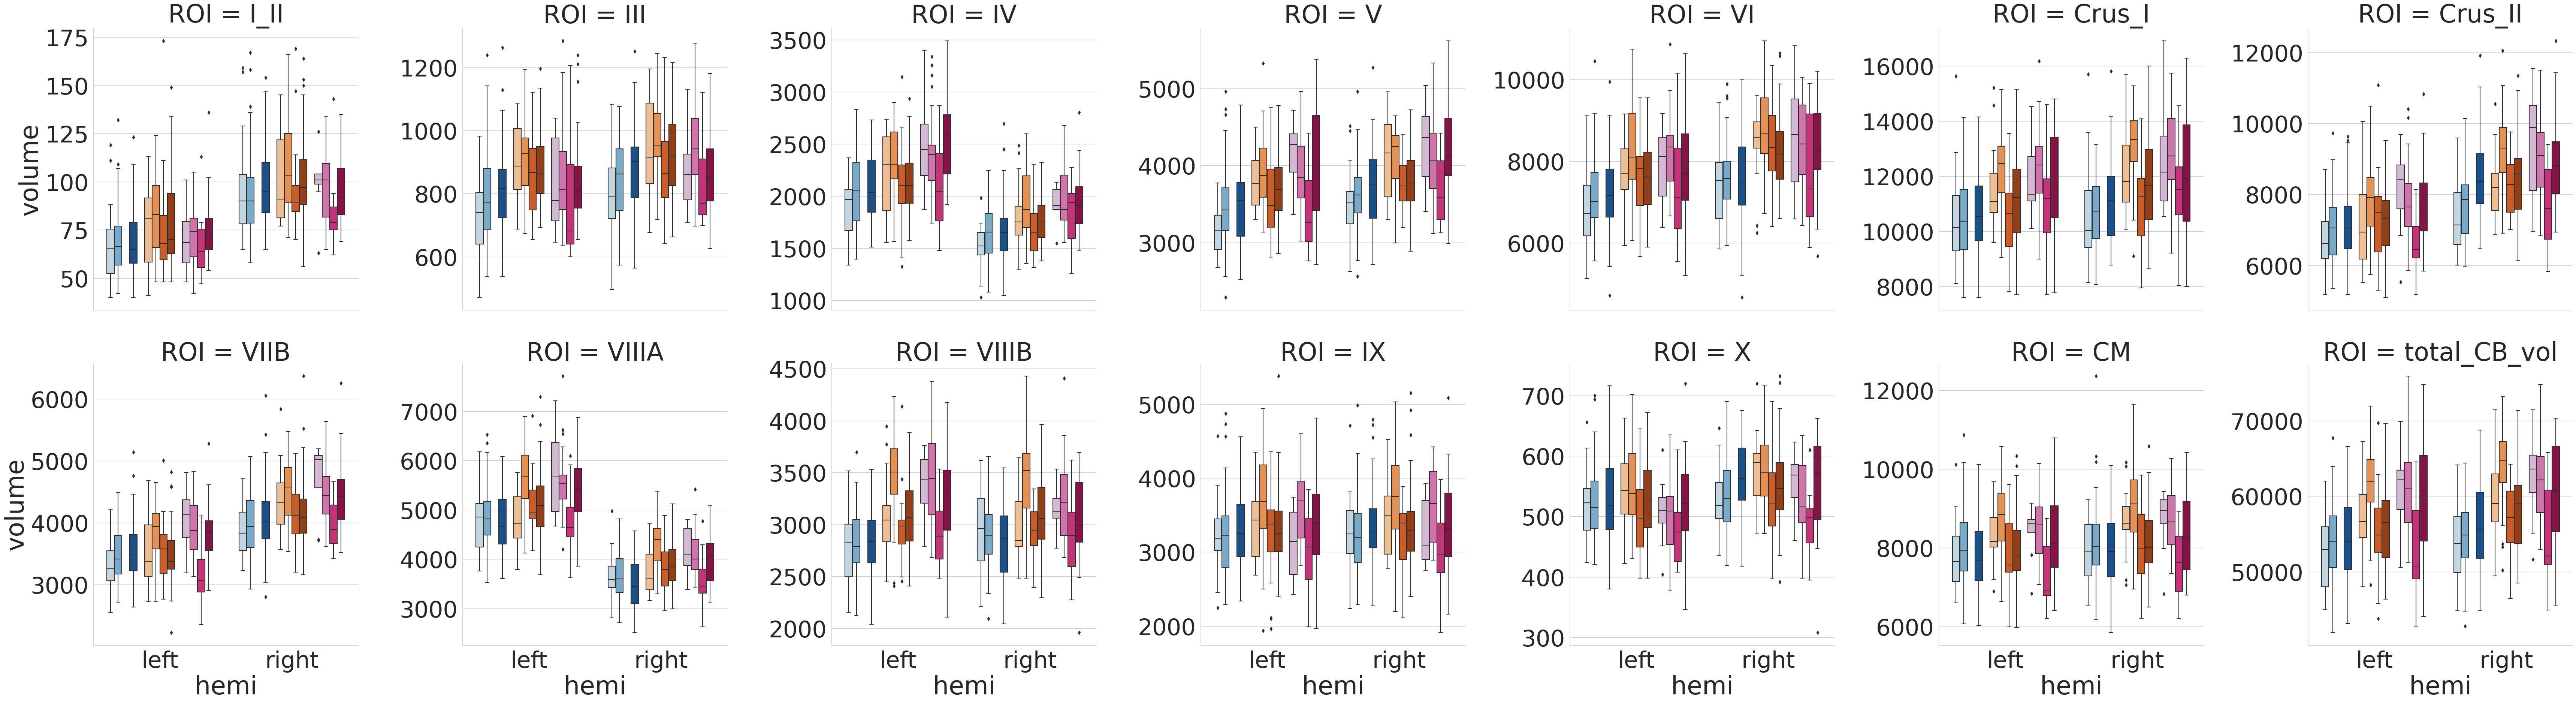

In [9]:
save_fig = True
CB_vol_df = CB_vol_df.drop(columns=["bids_id"])

CB_vol_df_melt = CB_vol_df.melt(
    id_vars=demo_cols + ["ds_group"],
    var_name="ROI", 
    value_name="volume",
)

plot_df = CB_vol_df_melt.copy()

color_list = [  my_colors.NIM_SERB_CONTROL.value, my_colors.NIM_SERB_PD.value,
                my_colors.NIM_METAL_CONTROL.value, my_colors.NIM_METAL_PD.value,
                "white",
                my_colors.QPN_CONTROL.value, my_colors.QPN_PD.value, 
                my_colors.QPN_older_CONTROL.value, my_colors.QPN_older_PD.value,
                "white",
                my_colors.PPMI_CONTROL.value, my_colors.PPMI_PD.value,
                my_colors.PPMI_older_CONTROL.value, my_colors.PPMI_older_PD.value              
              ]

palette = sns.color_palette(palette=color_list)

hue_order = ["NIMHANS-1-control", "NIMHANS-1-PD", "NIMHANS-2-control", "NIMHANS-2-PD", "",
             "QPN-young-control", "QPN-young-PD", "QPN-older-control", "QPN-older-PD", "",
             "PPMI-young-control",  "PPMI-young-PD","PPMI-older-control",  "PPMI-older-PD"] 


sns.set_theme(font_scale=4)

with sns.axes_style("whitegrid"):
    g = sns.catplot(y="volume",x="hemi", hue="ds_group", col="ROI", kind="box", col_wrap=7, hue_order=hue_order,
    palette=palette, data=plot_df, aspect=1, height=10, sharey=False, legend=False)
    # plt.legend(bbox_to_anchor =(1.7,0.1), loc='lower center',ncol=1, fontsize=40)
    # plt.legend(bbox_to_anchor =(0,2.5), loc='lower center',ncol=3, fontsize=40)
if save_fig:
    g.savefig(f"{figs_dir}/CB_vol.png")

In [10]:
CB_vol_df.groupby(["dataset","group"])["participant_id"].count()

dataset     group    
NIMHANS-1   PD           122
            control       44
NIMHANS-2   PD           129
PPMI-older  PD            53
            control       22
            prodromal      6
PPMI-young  PD            57
            control       16
            prodromal      5
QPN         PD           195
            control       47
QPN-older   PD           119
            control       45
QPN-young   PD            62
            control       28
Name: participant_id, dtype: int64

In [11]:
CB_vol_df.groupby(["dataset","group"])["age"].describe()

count       mean        std   min    25%    50%    75%  \
dataset    group                                                               
NIMHANS-1  PD         104.0  55.221154   7.189470  36.0  50.00  56.00  61.00   
           control     30.0  52.000000   5.907330  41.0  48.50  53.00  56.75   
NIMHANS-2  PD         115.0  53.834783  10.010460  24.0  46.00  55.00  61.00   
PPMI-older PD          53.0  69.509434   4.940502  63.0  65.00  69.00  72.00   
           control     22.0  67.909091   5.060671  63.0  64.00  66.00  70.75   
           prodromal    6.0  65.333333   1.366260  64.0  64.25  65.00  66.50   
PPMI-young PD          57.0  55.824561   5.241056  44.0  51.00  57.00  60.00   
           control     16.0  56.125000   5.175262  45.0  55.00  57.50  59.50   
           prodromal    5.0  60.800000   0.447214  60.0  61.00  61.00  61.00   
QPN        PD           0.0        NaN        NaN   NaN    NaN    NaN    NaN   
           control      0.0        NaN        NaN   NaN    NaN    NaN    NaN   
QPN-older  PD         119.0  71.055462   5.805516  63.2  66.25  70.70  74.25   
           control     45.0  70.706667   4.803048  63.1  67.80  70.80  73.10   
QPN-young  PD          62.0  54.922581   5.228623  40.8  51.40  55.60  58.30   
           control     28.0  54.771429   6.763128  43.4  47.20  56.75  61.10   

                       max  
dataset    group            
NIMHANS-1  PD         67.0  
           control    60.0  
NIMHANS-2  PD         72.0  
PPMI-older PD         82.0  
           control    80.0  
           prodromal  67.0  
PPMI-young PD         62.0  
           control    61.0  
           prodromal  61.0  
QPN        PD          NaN  
           control     NaN  
QPN-older  PD         88.3  
           control    80.4  
QPN-young  PD         62.6  
           control    62.5

### Statistical tests: OLS

In [12]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [13]:
def get_stats(stat_df, ind_var, dep_var, cat_vars, global_correction=False):
    cvar_str = ""
    for cvar in cat_vars:
        cvar_str = "".join([f"{cvar_str} + C({cvar})"])    

    if global_correction:
        formula = f"{ind_var} ~ {dep_var}{cvar_str} + {global_correction}"
    else:
        formula = f"{ind_var} ~ {dep_var}{cvar_str}"
        
    res = smf.ols(formula=formula, data=stat_df).fit()
    
    tval_df = pd.DataFrame(columns=["tvalues"], data=res.tvalues)
    pval_df = pd.DataFrame(columns=["pvalues"], data=res.pvalues)
    res_df = pd.concat([tval_df, pval_df], axis=1)
    res_df = res_df.reset_index().rename(columns={"index":"var"})

    return res_df, res, formula

### Replication analysis

In [14]:
dep_var = "age"
cat_vars = ["sex", "group"]
dataset_list = ["NIMHANS-1","QPN-young","QPN-older","PPMI-young","PPMI-older"] #"NIMHANS-1",

pval_thresh = 0.05

In [15]:
brain_roi_list = ['IandII', 'III', 'IV', 'V', 'VI', 'CrusI', 'CrusII','VIIB', 'VIIIA', 'VIIIB', 'IX', 'X', 'CM']
hemi_list = ["left", "right"]
global_correction = "total_CB_vol"

CB_vol_df = CB_vol_df.rename(columns={"I_II":"IandII", 'Crus_I':'CrusI', 'Crus_II':'CrusII'})


res_df = pd.DataFrame()
for ds in dataset_list:
    for ind_var in brain_roi_list:
        for hemi in hemi_list:
            # print(f"ds:{ds}, ind_var:{ind_var}")
            stat_df = CB_vol_df.copy()
            stat_df = stat_df[(stat_df["dataset"]==ds) & (stat_df["hemi"]==hemi)]
            if global_correction:
                _df, res, formula = get_stats(stat_df, ind_var, dep_var, cat_vars, global_correction)
            else:
                _df, res, formula = get_stats(stat_df, ind_var, dep_var, cat_vars)
            _df["ROI"] = ind_var
            _df["hemi"] = hemi
            _df["dataset"] = ds
            res_df = pd.concat([res_df, _df], axis=0)


res_df[(res_df["var"]=="C(group)[T.control]") & (res_df["pvalues"] < pval_thresh)]

,var,tvalues,pvalues,ROI,hemi,dataset
2,C(group)[T.control],2.107836,0.041697,V,right,QPN-young
2,C(group)[T.control],-3.004324,0.004474,VIIIA,left,QPN-young
2,C(group)[T.control],-2.406954,0.021664,IX,left,PPMI-young
2,C(group)[T.control],-2.200714,0.035090,IX,right,PPMI-young
2,C(group)[T.control],-3.089989,0.003847,VIIB,left,PPMI-older


In [16]:
formula

'CM ~ age + C(sex) + C(group) + total_CB_vol'